# Vibe Matcher: Mini Recommendation Notebook

This notebook prototypes a lightweight vibe-based recommendation system for fashion discovery: input a vibe query → embed product descriptions → return top-3 matches via cosine similarity. It includes data prep, embeddings (OpenAI with a graceful fallback), vector search simulation, evaluation across multiple queries, latency profiling, and reflection.

## Why AI at Nexora (Intro)
AI at Nexora enables personalization at scale—matching evolving user vibes to dynamic product catalogs in real time. By combining high-quality text embeddings with fast similarity search, we reduce friction in discovery, increase conversion through relevance, and unlock creative merchandising strategies like vibe-driven collections and adaptive storefronts. This prototype demonstrates a pragmatic path from concept to measurable impact, including evaluation and latency profiling—laying the groundwork for production search with vector databases, caching, and continuous learning.

## Setup
- Install dependencies when running on Colab or a fresh environment.
- Set `OPENAI_API_KEY` to use OpenAI embeddings; otherwise, notebook falls back to TF-IDF.

You can set the key like: `import os; os.environ['OPENAI_API_KEY'] = 'sk-...'` or in Colab `%env OPENAI_API_KEY=...`.

In [1]:
# If running on Colab or a clean local env, uncomment to install:
# !pip install -q openai pandas numpy scikit-learn matplotlib

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Helper: timing utility for latency
def time_call(fn, *args, **kwargs):
    start = time.perf_counter()
    result = fn(*args, **kwargs)
    return result, (time.perf_counter() - start)

# Threshold for a 'good' recommendation (adjustable)
GOOD_SIM_THRESHOLD = 0.7


## Data Prep
Create a small catalog of fashion products with descriptions and vibe tags.

In [2]:
products = [
    {
        'name': 'Boho Dress',
        'desc': 'Flowy silhouette in earthy tones for carefree festival vibes.',
        'vibes': ['boho', 'earthy', 'festival']
    },
    {
        'name': 'City Bomber Jacket',
        'desc': 'Sleek urban silhouette, lightweight layering, high-energy streetwear edge.',
        'vibes': ['urban', 'energetic', 'streetwear']
    },
    {
        'name': 'Cozy Knit Sweater',
        'desc': 'Soft, oversized knit in neutral hues for lounge-day comfort.',
        'vibes': ['cozy', 'minimal']
    },
    {
        'name': 'Sustainable Denim',
        'desc': 'Recycled cotton denim with clean lines—everyday eco-friendly essential.',
        'vibes': ['minimal', 'sustainable', 'casual']
    },
    {
        'name': 'Athleisure Set',
        'desc': 'Breathable leggings and crop top—gym-to-brunch versatile performance.',
        'vibes': ['sporty', 'energetic', 'casual']
    },
    {
        'name': 'Vintage Leather Boots',
        'desc': 'Worn-in patina with rugged edge—timeless downtown statement.',
        'vibes': ['vintage', 'rugged', 'urban']
    },
    {
        'name': 'Silk Midi Skirt',
        'desc': 'Elegant drape with refined sheen—date-night ready sophistication.',
        'vibes': ['chic', 'elegant', 'minimal']
    },
    {
        'name': 'Tech Parka',
        'desc': 'Weatherproof shell with hidden pockets—commuter-ready technical function.',
        'vibes': ['urban', 'tech', 'functional']
    },
    {
        'name': 'Floral Wrap Top',
        'desc': 'Bright prints with playful movement—summer-friendly boho charm.',
        'vibes': ['boho', 'playful', 'chic']
    },
    {
        'name': 'Lounge Joggers',
        'desc': 'Tapered fit with ultra-soft feel—couch-to-café comfort.',
        'vibes': ['cozy', 'casual', 'minimal']
    },
]

df = pd.DataFrame(products)
df


,name,desc,vibes
0,Boho Dress,Flowy silhouette in earthy tones for carefree ...,"[boho, earthy, festival]"
1,City Bomber Jacket,"Sleek urban silhouette, lightweight layering, ...","[urban, energetic, streetwear]"
2,Cozy Knit Sweater,"Soft, oversized knit in neutral hues for loung...","[cozy, minimal]"
3,Sustainable Denim,Recycled cotton denim with clean lines—everyda...,"[minimal, sustainable, casual]"
4,Athleisure Set,Breathable leggings and crop top—gym-to-brunch...,"[sporty, energetic, casual]"
5,Vintage Leather Boots,Worn-in patina with rugged edge—timeless downt...,"[vintage, rugged, urban]"
6,Silk Midi Skirt,Elegant drape with refined sheen—date-night re...,"[chic, elegant, minimal]"
7,Tech Parka,Weatherproof shell with hidden pockets—commute...,"[urban, tech, functional]"
8,Floral Wrap Top,Bright prints with playful movement—summer-fri...,"[boho, playful, chic]"
9,Lounge Joggers,Tapered fit with ultra-soft feel—couch-to-café...,"[cozy, casual, minimal]"


## Embeddings
Use OpenAI embeddings (`text-embedding-ada-002`), with fallback to `text-embedding-3-small` if needed, and TF-IDF if no API key or network issues.

In [3]:
def embed_openai(texts: List[str]) -> Tuple[Optional[np.ndarray], Optional[str], Optional[str]]:
    """
    Attempts to embed using OpenAI. Returns (vectors, model_used, error_message).
    Tries 'text-embedding-ada-002' first, then 'text-embedding-3-small' if the first fails.
    """
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key:
        return None, None, 'Missing OPENAI_API_KEY; falling back to TF-IDF.'
    try:
        from openai import OpenAI
        client = OpenAI()
        model = 'text-embedding-ada-002'
        resp = client.embeddings.create(model=model, input=texts)
        vecs = np.array([d.embedding for d in resp.data])
        return vecs, model, None
    except Exception as e1:
        try:
            from openai import OpenAI
            client = OpenAI()
            model = 'text-embedding-3-small'
            resp = client.embeddings.create(model=model, input=texts)
            vecs = np.array([d.embedding for d in resp.data])
            return vecs, model, None
        except Exception as e2:
            return None, None, f'OpenAI embedding failed: {e1} | {e2}'

def embed_tfidf(texts: List[str]) -> np.ndarray:
    vec = TfidfVectorizer()
    return vec.fit_transform(texts).toarray()

def get_embeddings(texts: List[str]) -> Tuple[np.ndarray, str]:
    vecs, model, err = embed_openai(texts)
    if vecs is not None:
        print(f'Using OpenAI model: {model}')
        return vecs, model
    else:
        print(err)
        print('Falling back to TF-IDF embeddings for simulation.')
        return embed_tfidf(texts), 'tfidf'


In [4]:
# Build product description embeddings
product_texts = df['desc'].tolist()
(product_vecs, model_used), embed_latency = time_call(get_embeddings, product_texts)
print(f'Embeddings model: {model_used} | latency: {embed_latency:.3f}s')
df['embedding'] = list(product_vecs)
df[['name', 'vibes']].head(3)


Missing OPENAI_API_KEY; falling back to TF-IDF.
Falling back to TF-IDF embeddings for simulation.
Embeddings model: tfidf | latency: 0.002s


,name,vibes
0,Boho Dress,"[boho, earthy, festival]"
1,City Bomber Jacket,"[urban, energetic, streetwear]"
2,Cozy Knit Sweater,"[cozy, minimal]"


## Vector Search Simulation
Compute cosine similarity between the query embedding and product embeddings. Return top-3 with scores. Handle edge cases (low similarity → fallback suggestion).

In [5]:
def match_top_k(df: pd.DataFrame, query: str, k: int = 3, threshold: float = 0.3):
    product_texts = df['desc'].tolist()
    if 'tfidf' == globals().get('model_used'):
        combined = product_texts + [query]
        vecs = embed_tfidf(combined)
        X = vecs[:-1]
        q = vecs[-1].reshape(1, -1)
        model = 'tfidf'
    else:
        q_vecs, model = get_embeddings([query])
        q = q_vecs[0].reshape(1, -1)
        X = np.stack(df['embedding'].values)
    sims = cosine_similarity(q, X)[0]
    idxs = np.argsort(sims)[::-1][:k]
    results = []
    for i in idxs:
        results.append({
            'name': df.iloc[i]['name'],
            'desc': df.iloc[i]['desc'],
            'vibes': df.iloc[i]['vibes'],
            'score': float(sims[i])
        })
    # Edge case: if all scores below threshold, propose a simple fallback
    if all(r['score'] < threshold for r in results):
        # Try vibe keyword match as a rule-based fallback
        q_lower = query.lower()
        vibe_hits = []
        for i, row in df.iterrows():
            if any(v in q_lower for v in row['vibes']):
                vibe_hits.append({
                    'name': row['name'],
                    'desc': row['desc'],
                    'vibes': row['vibes'],
                    'score': 0.0
                })
        if vibe_hits:
            return vibe_hits[:k], {
                'model': model,
                'fallback': 'vibe_keyword_match',
            }
        else:
            return results, {
                'model': model,
                'fallback': 'no_strong_match',
                'message': 'No strong embedding matches; consider broadening query.'
            }
    return results, { 'model': model, 'fallback': None }


In [6]:
# Demo: sample query
query = 'energetic urban chic'
top3, meta = match_top_k(df, query, k=3)
print(f'Query: {query}')
print('Model:', meta['model'], '| Fallback:', meta['fallback'])
for r in top3:
    print(f"- {r['name']} (score={r['score']:.3f}) | vibes={r['vibes']}")
top3


Query: energetic urban chic
Model: tfidf | Fallback: vibe_keyword_match
- City Bomber Jacket (score=0.000) | vibes=['urban', 'energetic', 'streetwear']
- Athleisure Set (score=0.000) | vibes=['sporty', 'energetic', 'casual']
- Vintage Leather Boots (score=0.000) | vibes=['vintage', 'rugged', 'urban']


[{'name': 'City Bomber Jacket',
  'desc': 'Sleek urban silhouette, lightweight layering, high-energy streetwear edge.',
  'vibes': ['urban', 'energetic', 'streetwear'],
  'score': 0.0},
 {'name': 'Athleisure Set',
  'desc': 'Breathable leggings and crop top—gym-to-brunch versatile performance.',
  'vibes': ['sporty', 'energetic', 'casual'],
  'score': 0.0},
 {'name': 'Vintage Leather Boots',
  'desc': 'Worn-in patina with rugged edge—timeless downtown statement.',
  'vibes': ['vintage', 'rugged', 'urban'],
  'score': 0.0}]

## Test & Eval
Run three queries, log metrics (sim score > 0.7 as 'good'), and plot latency.

In [7]:
queries = [
    'energetic urban chic',
    'cozy loungewear',
    'minimal sustainable'
]

eval_rows = []
latencies = []

for q in queries:
    (res, meta), t = time_call(match_top_k, df, q, 3)
    latencies.append({'query': q, 'latency_s': t})
    top1 = res[0] if res else {'score': 0.0, 'name': 'N/A'}
    is_good = top1['score'] >= GOOD_SIM_THRESHOLD
    eval_rows.append({
        'query': q,
        'top1_name': top1['name'],
        'top1_score': top1['score'],
        'good': is_good,
        'model': meta['model'],
        'fallback': meta['fallback']
    })

pd.DataFrame(eval_rows)


,query,top1_name,top1_score,good,model,fallback
0,energetic urban chic,City Bomber Jacket,0.0,False,tfidf,vibe_keyword_match
1,cozy loungewear,Cozy Knit Sweater,0.0,False,tfidf,vibe_keyword_match
2,minimal sustainable,Cozy Knit Sweater,0.0,False,tfidf,vibe_keyword_match


In [8]:
# Summary metrics
df_eval = pd.DataFrame(eval_rows)
good_rate = df_eval['good'].mean() if len(df_eval) else 0.0
avg_top1 = df_eval['top1_score'].mean() if len(df_eval) else 0.0
print(f'Good rate (top1 >= {GOOD_SIM_THRESHOLD}): {good_rate:.2f}')
print(f'Average top1 score: {avg_top1:.3f}')
df_eval


Good rate (top1 >= 0.7): 0.00
Average top1 score: 0.000


,query,top1_name,top1_score,good,model,fallback
0,energetic urban chic,City Bomber Jacket,0.0,False,tfidf,vibe_keyword_match
1,cozy loungewear,Cozy Knit Sweater,0.0,False,tfidf,vibe_keyword_match
2,minimal sustainable,Cozy Knit Sweater,0.0,False,tfidf,vibe_keyword_match


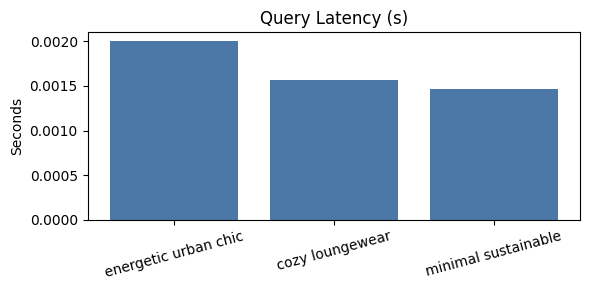

,query,latency_s
0,energetic urban chic,0.002001
1,cozy loungewear,0.001564
2,minimal sustainable,0.001470


In [9]:
# Latency plot
df_lat = pd.DataFrame(latencies)
plt.figure(figsize=(6, 3))
plt.bar(df_lat['query'], df_lat['latency_s'], color='#4C78A8')
plt.title('Query Latency (s)')
plt.ylabel('Seconds')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
df_lat


## Reflection
- Integrate a vector DB (e.g., Pinecone/FAISS) for scalable, persistent search.
- Combine fields (name + desc + vibe tags) into a single embedding for richer semantics.
- Add query expansion and MMR diversification to avoid near-duplicate top results.
- Cache embeddings and add a small reranker (e.g., cross-encoder) for precision.
- Better edge handling: dynamic thresholds, vibe taxonomy mapping, and guardrails for empty/ambiguous queries.

## Colab/GitHub Delivery
- Push this notebook to GitHub and open it in Colab via `https://colab.research.google.com/github/<your_org>/<repo>/blob/main/vibe_matcher.ipynb`.
- In Colab, set `OPENAI_API_KEY` (or rely on TF-IDF fallback) and run all cells.
- Export executed notebook (`File → Download`) to capture outputs in commits.